# Comparing taxonomic profiles using the CAMI data

Profilers used:
* [mOTUs](https://github.com/motu-tool/mOTUs) version 3.0.3
* [MetaPhlAn](https://github.com/biobakery/MetaPhlAn) version 4.0.3
* [Bracken](https://github.com/jenniferlu717/Bracken) version 2.8
* [KMA](https://bitbucket.org/genomicepidemiology/kma) version 1.4.7

For KMA, these different reference databases have been evaluated:
* Silva (20200116)
* Genomic (20220524)
* mOTUs db (20221205)

In [258]:
import pandas as pd
import os
import glob
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import warnings
import string
import matplotlib.gridspec as gridspec
import subprocess
from matplotlib.patches import Patch
import math

sns.set_context('paper')

ranks = ['superkingdom','phylum','class','order','family','genus','species']
rank2letter = {'superkingdom': 'sk', 'phylum': 'p', 'order': 'o', 'family': 'f', 'genus': 'g', 'species': 's', 'class': 'c'}

alphabet = list(string.ascii_lowercase)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# from https://frl.publisso.de/data/frl:6425518/README.md
airways=[4,7,8,9,10,11,12,23,26,27] 
skin=[1,13,14,15,16,17,18,19,20,28]
urogenital=[0,2,3,5,6,21,22,24,25]

gastrointestinal=[0,1,2,3,4,5,9,10,11,12]
oral=[6,7,8,13,14,15,16,17,18,19]

airskinurogenital = {str(n): l for l, v in zip(['airways', 'skin', 'urogenital'], [airways, skin, urogenital]) for n in v}
gastrooral = {n: l for l, v in zip(['gastrointestinal', 'oral'], [gastrointestinal, oral]) for n in v}

name2group = {
    **{f'marine_sample{n}': 'marine' for n in range(10)},
    **{f'plant_associated_sample{n}': 'plant_associated' for n in range(25)},
    **{f'airskinurogenital_sample{n}': 'airways' for n in airways},
    **{f'airskinurogenital_sample{n}': 'skin' for n in skin},
    **{f'airskinurogenital_sample{n}': 'urogenital' for n in urogenital},
    **{f'gastrooral_sample{n}': 'gastrointestinal' for n in gastrointestinal},
    **{f'gastrooral_sample{n}': 'oral' for n in oral},
    
}
def extract_sample_groups(dataframe):
    dataframe['sample_number'] = dataframe['sample'].apply(lambda x: x.split('_sample')[-1])
    dataframe['sample_group'] = dataframe['sample'].map(name2group)

## Run OPAL

In [313]:
rerun = False
if rerun:
    goldens=glob.glob(os.path.join('cami_profiles', '*' + '_golden.txt'))

    for g in goldens:

        p = glob.glob(g.replace('_golden.txt', '*.combined.cami'))
        labels = ",".join([v.split('_')[-1].split('.')[0] for v in p])

        outDIR = g.split('/')[-1].split('_')[0] + '_opal'

        cmd = f"python OPAL/opal.py --silent -g {g} -l {labels} -o {outDIR} --filter 1 {' '.join(p)}"
        p = subprocess.run(cmd, shell=True, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
        
opal = pd.concat([pd.read_csv(f, sep='\t') for f in glob.glob('*_opal/results.tsv')])
extract_sample_groups(opal)

## Setup palettes and other plotting stuff

In [331]:
def figure_saver(fig, prefix, contexts=['paper'], formats=['.png', '.pdf', '.tiff']):
    
    for context in contexts:
        
        for fformat in formats:
            fname = f"{prefix}_{context}{fformat}"
            fig.savefig(fname, bbox_inches = "tight")
    
    sns.set_context('paper')
    
def get_cmap(labels, name='viridis'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    cmap = plt.get_cmap(name, len(labels))#.colors
    
    return {l: cmap(i) for i, l in enumerate(labels)}

In [5]:
opalMeans['tool'].unique()

array(['Gold standard', 'KMA-Silva', 'KMA-genomic', 'KMA-mOTUs',
       'MetaPhlan', 'bracken', 'mOTUs'], dtype=object)

In [6]:
tool_palette = get_cmap(labels=opalMeans['tool'].unique().tolist(), name='Set2')
tool_order = ['Gold standard', 'bracken', 'MetaPhlan', 'mOTUs', 'KMA-Silva', 'KMA-genomic', 'KMA-mOTUs']

env_palette = get_cmap(opalMeans['sample_group'].unique().tolist(), 'Set1')
env_order = ['oral', 'skin', 'airways', 'urogenital', 'gastrointestinal', 'marine', 'plant_associated']

In [249]:
tool_legend = [Patch(facecolor=tool_palette[k], label=k) for k in tool_order]
rank_legend = [Patch(facecolor='white',label=f"{rank2letter[r]}: {r}") for r in ranks]

## Comparing hits

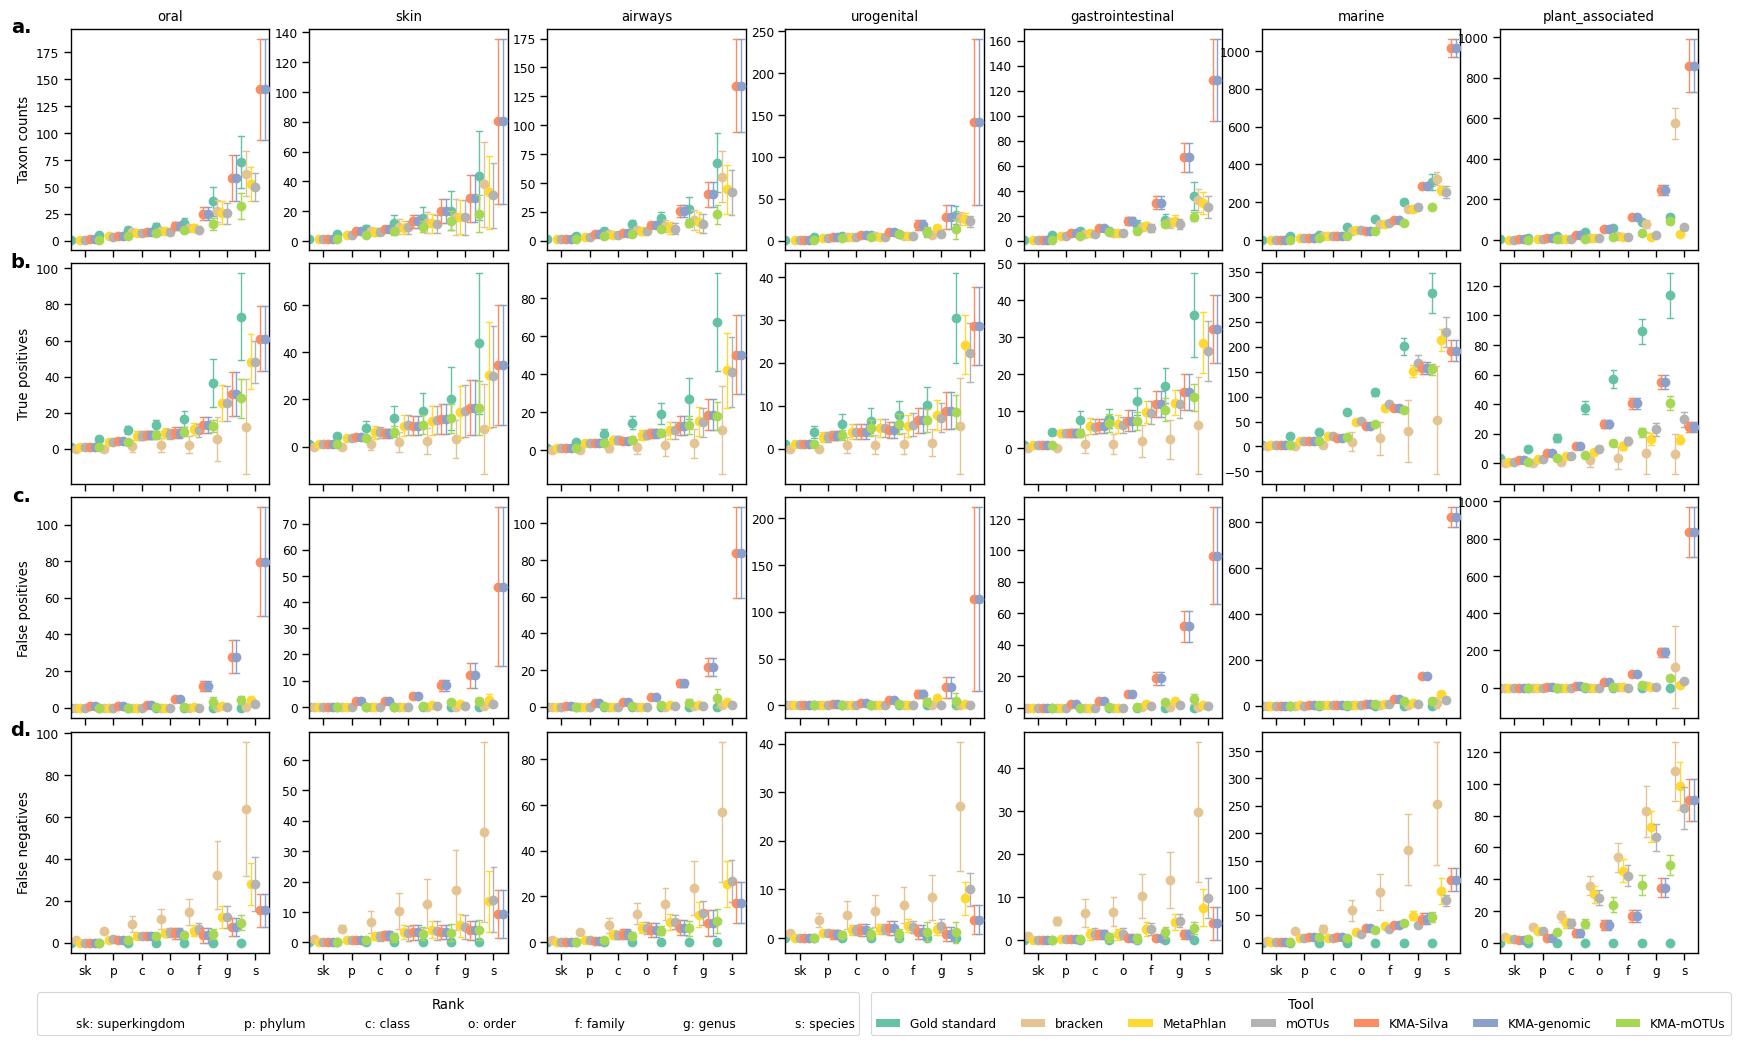

In [332]:
dim = 3
metrics = ['Taxon counts', 'True positives', 'False positives', 'False negatives']

nmetrics = len(metrics)
nenvs = len(env_order)

fig, axes = plt.subplots(nmetrics, nenvs, figsize=(dim*nenvs, dim*nmetrics), sharex=True, gridspec_kw={'hspace': 0.06})

for i, metric in enumerate(metrics):
        
    for j, (ax, env) in enumerate(zip(axes[i, :].flatten(), env_order)):
        
        d = opal.loc[
            (opal['sample_group'] == env) &
            (opal['metric'] == metric) &
            (opal['rank'].isin(ranks))
        ].copy()
        
        d.loc[
        (d['rank'] == 'species') &
        (d['tool'] == 'KMA-mOTUs'),
        'value'
        ] = pd.NA
        
        d['x'] = d['rank'].map(rank2letter)
        
        sns.pointplot(
            data = d,
            x = 'x',
            y = 'value',
            hue = 'tool',
            hue_order=tool_order,
            palette=tool_palette,
            join=False,
            errorbar='sd',
            dodge=1,
            errwidth=1,
            ax=ax,
            capsize=.2

        )
        
        if i == 0:
            ax.set_title(env)
        

        if j == 0:
            ax.set_ylabel(metric)
            ax.text(-0.2, 1.05, alphabet[i] + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
        else:
            ax.set_ylabel('')
        
        ax.get_legend().remove()
        ax.set_xlabel('')
        
        
# add legends to bottom of plot
axes[-1, 0].legend(handles=rank_legend, ncol=len(rank_legend), title='Rank', loc='lower left', bbox_to_anchor=(-.2, -.4))
axes[-1, -3].legend(handles=tool_legend, ncol=len(tool_legend), title='Tool', loc='lower left', bbox_to_anchor=(-.8, -.4))

figure_saver(fig=fig, prefix='paper_figures/number_of_hits_filtered', contexts=['talk', 'paper'])

In [333]:
opal.metric.unique()

array(['Bray-Curtis distance', 'Shannon diversity',
       'Shannon equitability', 'True positives', 'False negatives',
       'False positives', 'Completeness', 'Purity', 'F1 score',
       'Jaccard index', 'L1 norm error', 'Weighted UniFrac error',
       'Unweighted UniFrac error', 'Weighted UniFrac (CAMI)',
       'Unweighted UniFrac (CAMI)', 'Sum of abundances', 'Taxon counts',
       'Bray-Curtis distance (unfiltered)',
       'Shannon diversity (unfiltered)',
       'Shannon equitability (unfiltered)', 'True positives (unfiltered)',
       'False negatives (unfiltered)', 'False positives (unfiltered)',
       'Completeness (unfiltered)', 'Purity (unfiltered)',
       'F1 score (unfiltered)', 'Jaccard index (unfiltered)',
       'L1 norm error (unfiltered)',
       'Weighted UniFrac error (unfiltered)',
       'Unweighted UniFrac error (unfiltered)',
       'Weighted UniFrac (CAMI) (unfiltered)',
       'Unweighted UniFrac (CAMI) (unfiltered)',
       'Sum of abundances (unfilter

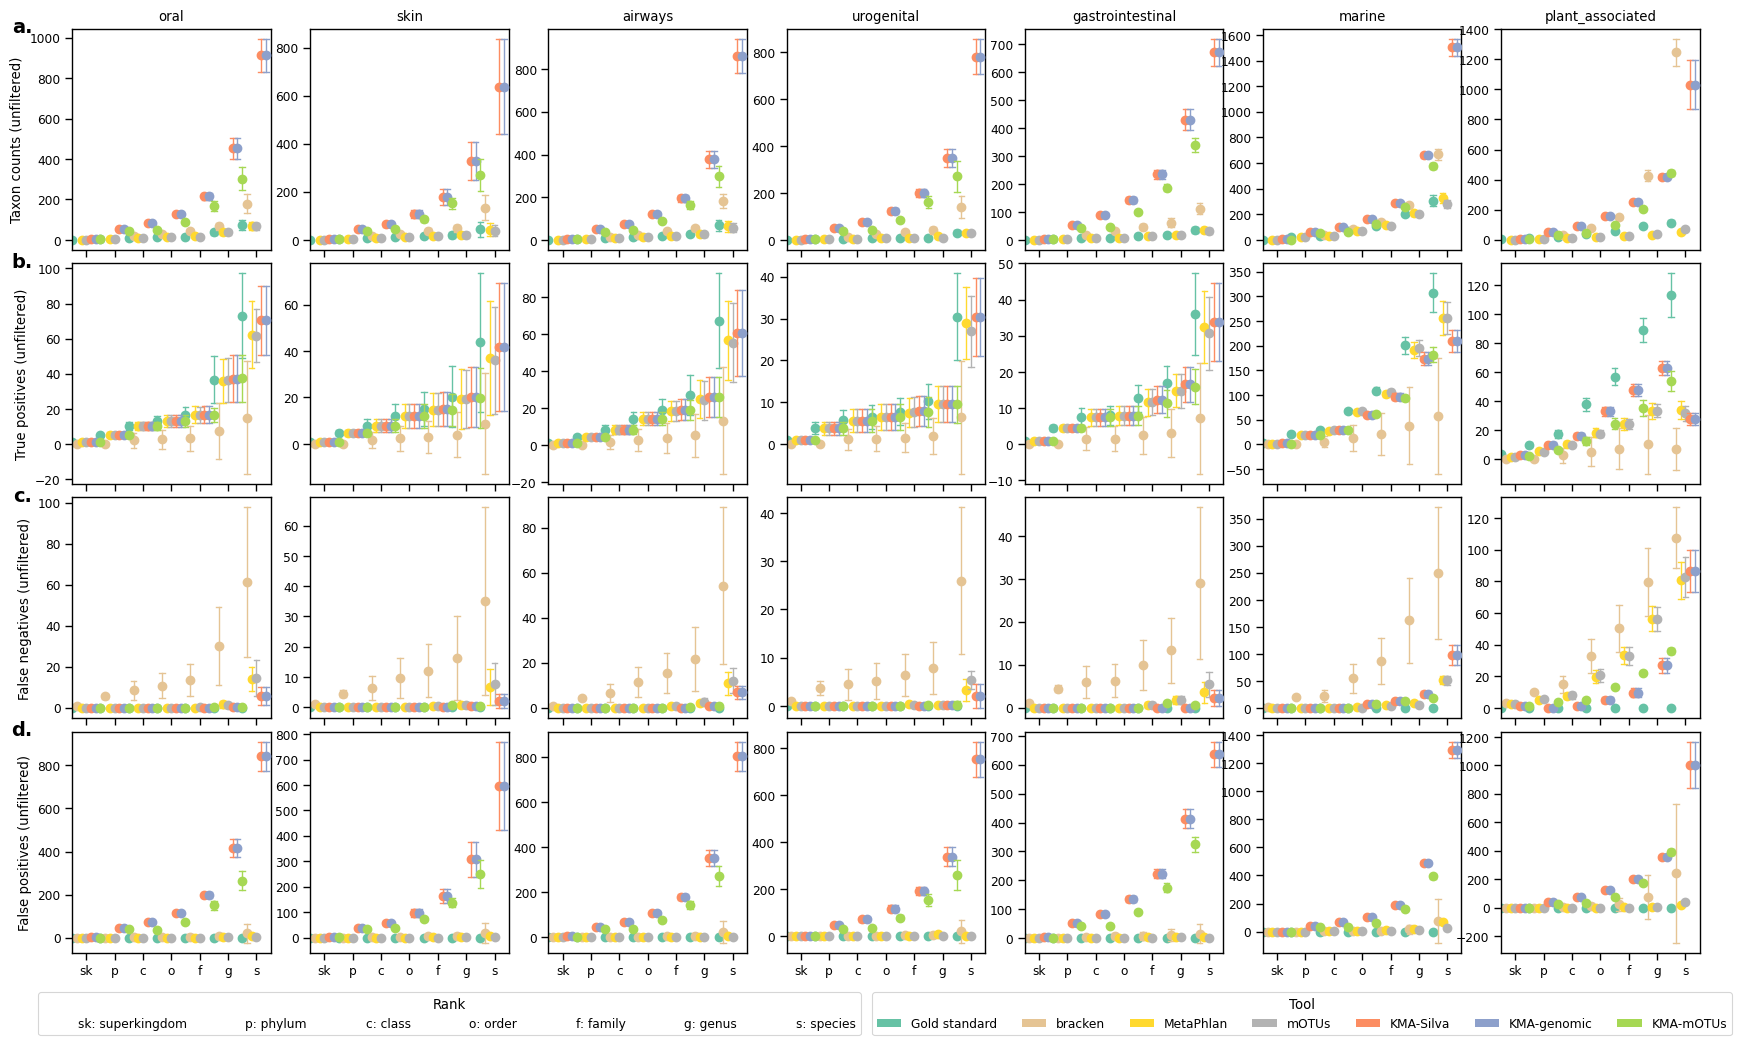

In [336]:
dim = 3
metrics = ['Taxon counts (unfiltered)', 'True positives (unfiltered)', 'False negatives (unfiltered)', 'False positives (unfiltered)']

nmetrics = len(metrics)
nenvs = len(env_order)

fig, axes = plt.subplots(nmetrics, nenvs, figsize=(dim*nenvs, dim*nmetrics), sharex=True, gridspec_kw={'hspace': 0.06})

for i, metric in enumerate(metrics):
        
    for j, (ax, env) in enumerate(zip(axes[i, :].flatten(), env_order)):
        
        d = opal.loc[
            (opal['sample_group'] == env) &
            (opal['metric'] == metric) &
            (opal['rank'].isin(ranks))
        ].copy()
        
        d.loc[
        (d['rank'] == 'species') &
        (d['tool'] == 'KMA-mOTUs'),
        'value'
        ] = pd.NA
        
        d['x'] = d['rank'].map(rank2letter)
        
        sns.pointplot(
            data = d,
            x = 'x',
            y = 'value',
            hue = 'tool',
            hue_order=tool_order,
            palette=tool_palette,
            join=False,
            errorbar='sd',
            dodge=1,
            errwidth=1,
            ax=ax,
            capsize=.2

        )
        
        if i == 0:
            ax.set_title(env)
        

        if j == 0:
            ax.set_ylabel(metric)
            ax.text(-0.2, 1.05, alphabet[i] + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
        else:
            ax.set_ylabel('')
        
        ax.get_legend().remove()
        ax.set_xlabel('')
        
        
# add legends to bottom of plot
axes[-1, 0].legend(handles=rank_legend, ncol=len(rank_legend), title='Rank', loc='lower left', bbox_to_anchor=(-.2, -.4))
axes[-1, -3].legend(handles=tool_legend, ncol=len(tool_legend), title='Tool', loc='lower left', bbox_to_anchor=(-.8, -.4))

figure_saver(fig=fig, prefix='paper_figures/number_of_hits_unfiltered', contexts=['talk', 'paper'])

## Recall (Completeness) and Precision (Purity)

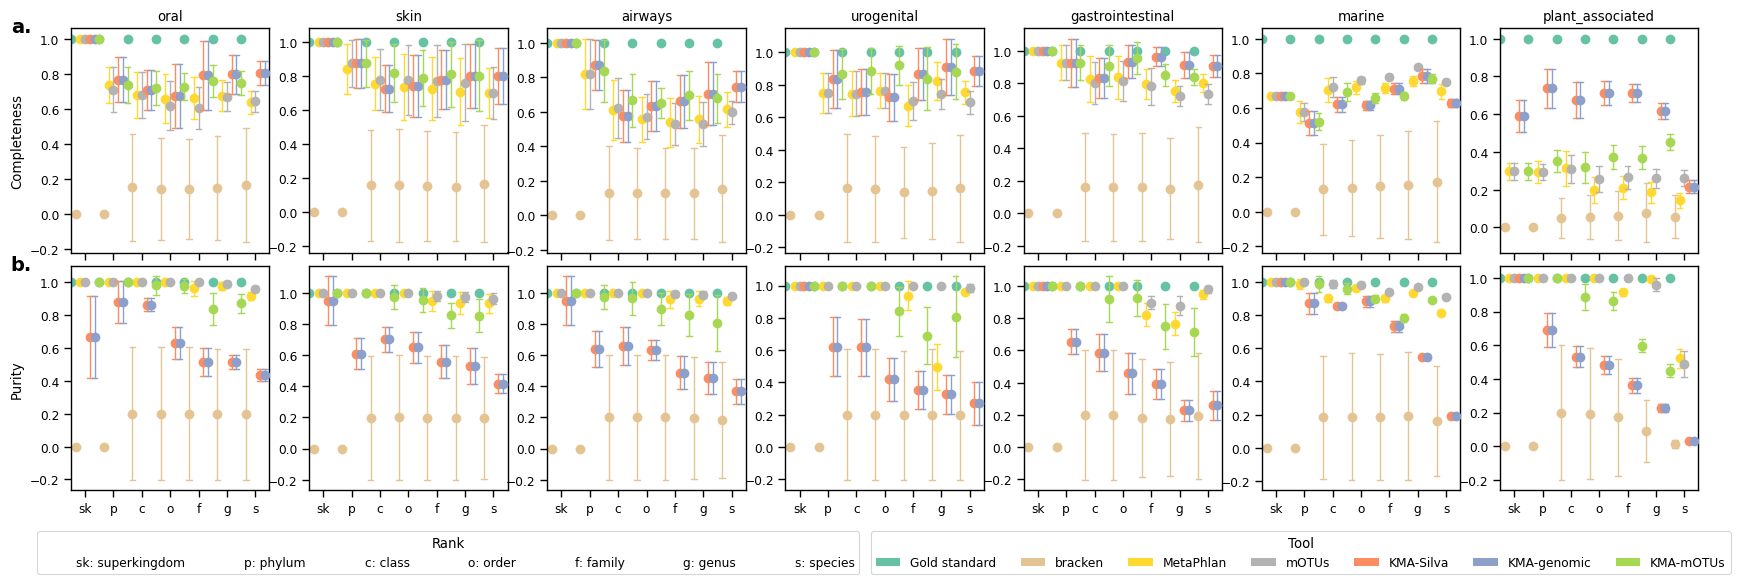

In [337]:
dim = 3
metrics = ['Completeness', 'Purity']

nmetrics = len(metrics)
nenvs = len(env_order)

fig, axes = plt.subplots(nmetrics, nenvs, figsize=(dim*nenvs, dim*nmetrics), sharex=True, gridspec_kw={'hspace': 0.06})

for i, metric in enumerate(metrics):
        
    for j, (ax, env) in enumerate(zip(axes[i, :].flatten(), env_order)):
        
        d = opal.loc[
            (opal['sample_group'] == env) &
            (opal['metric'] == metric) &
            (opal['rank'].isin(ranks))
        ].copy()
        
        d.loc[
        (d['rank'] == 'species') &
        (d['tool'] == 'KMA-mOTUs'),
        'value'
        ] = pd.NA
        
        d['x'] = d['rank'].map(rank2letter)
        
        sns.pointplot(
            data = d,
            x = 'x',
            y = 'value',
            hue = 'tool',
            hue_order=tool_order,
            palette=tool_palette,
            join=False,
            errorbar='sd',
            dodge=1,
            errwidth=1,
            ax=ax,
            capsize=.2

        )
        
        if i == 0:
            ax.set_title(env)
        

        if j == 0:
            ax.set_ylabel(metric)
            ax.text(-0.2, 1.05, alphabet[i] + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
        else:
            ax.set_ylabel('')
        
        ax.get_legend().remove()
        ax.set_xlabel('')
        
        
# add legends to bottom of plot
axes[-1, 0].legend(handles=rank_legend, ncol=len(rank_legend), title='Rank', loc='lower left', bbox_to_anchor=(-.2, -.4))
axes[-1, -3].legend(handles=tool_legend, ncol=len(tool_legend), title='Tool', loc='lower left', bbox_to_anchor=(-.8, -.4))

figure_saver(fig=fig, prefix='paper_figures/completeness_purity_filtered', contexts=['talk', 'paper'])

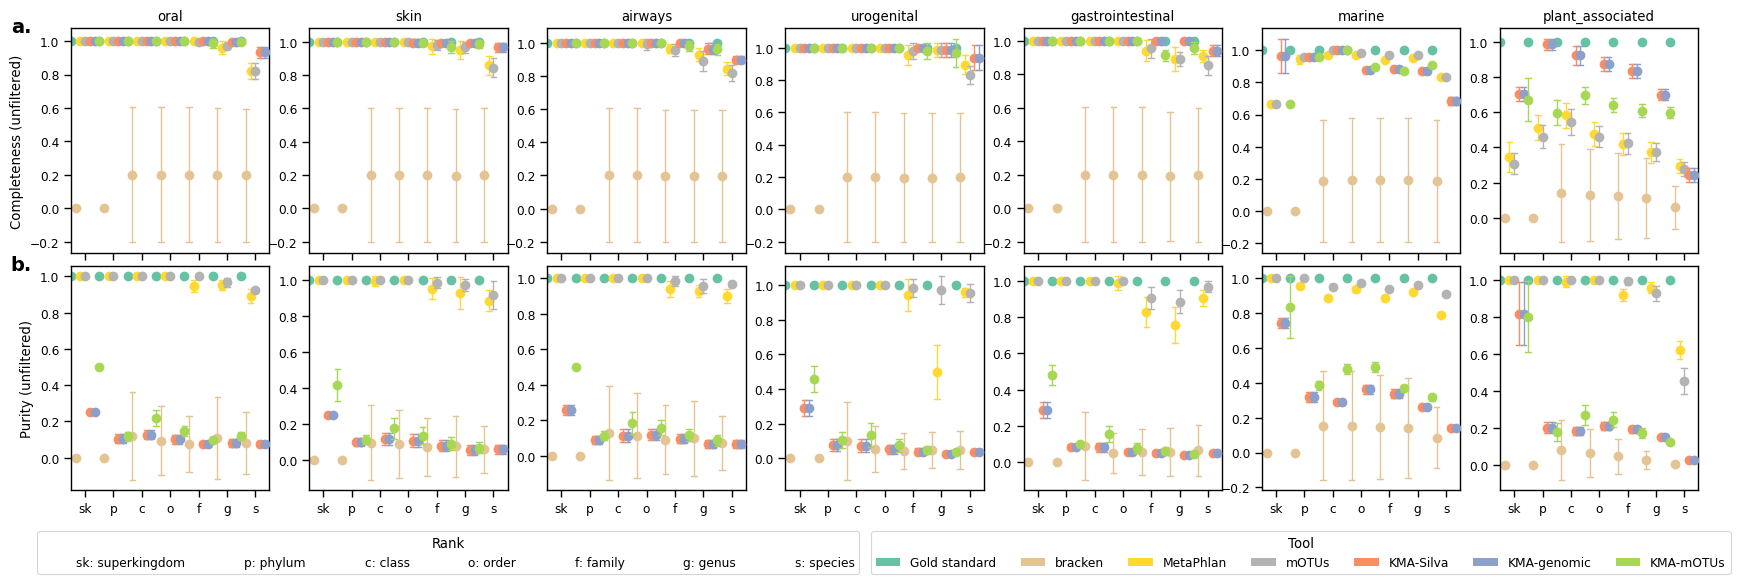

In [338]:
dim = 3
metrics = ['Completeness (unfiltered)', 'Purity (unfiltered)']

nmetrics = len(metrics)
nenvs = len(env_order)

fig, axes = plt.subplots(nmetrics, nenvs, figsize=(dim*nenvs, dim*nmetrics), sharex=True, gridspec_kw={'hspace': 0.06})

for i, metric in enumerate(metrics):
        
    for j, (ax, env) in enumerate(zip(axes[i, :].flatten(), env_order)):
        
        d = opal.loc[
            (opal['sample_group'] == env) &
            (opal['metric'] == metric) &
            (opal['rank'].isin(ranks))
        ].copy()
        
        d.loc[
        (d['rank'] == 'species') &
        (d['tool'] == 'KMA-mOTUs'),
        'value'
        ] = pd.NA
        
        d['x'] = d['rank'].map(rank2letter)
        
        sns.pointplot(
            data = d,
            x = 'x',
            y = 'value',
            hue = 'tool',
            hue_order=tool_order,
            palette=tool_palette,
            join=False,
            errorbar='sd',
            dodge=1,
            errwidth=1,
            ax=ax,
            capsize=.2

        )
        
        if i == 0:
            ax.set_title(env)
        

        if j == 0:
            ax.set_ylabel(metric)
            ax.text(-0.2, 1.05, alphabet[i] + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
        else:
            ax.set_ylabel('')
        
        ax.get_legend().remove()
        ax.set_xlabel('')
        
        
# add legends to bottom of plot
axes[-1, 0].legend(handles=rank_legend, ncol=len(rank_legend), title='Rank', loc='lower left', bbox_to_anchor=(-.2, -.4))
axes[-1, -3].legend(handles=tool_legend, ncol=len(tool_legend), title='Tool', loc='lower left', bbox_to_anchor=(-.8, -.4))

figure_saver(fig=fig, prefix='paper_figures/completeness_purity_unfiltered', contexts=['talk', 'paper'])

## Sum of abundances and F1 score

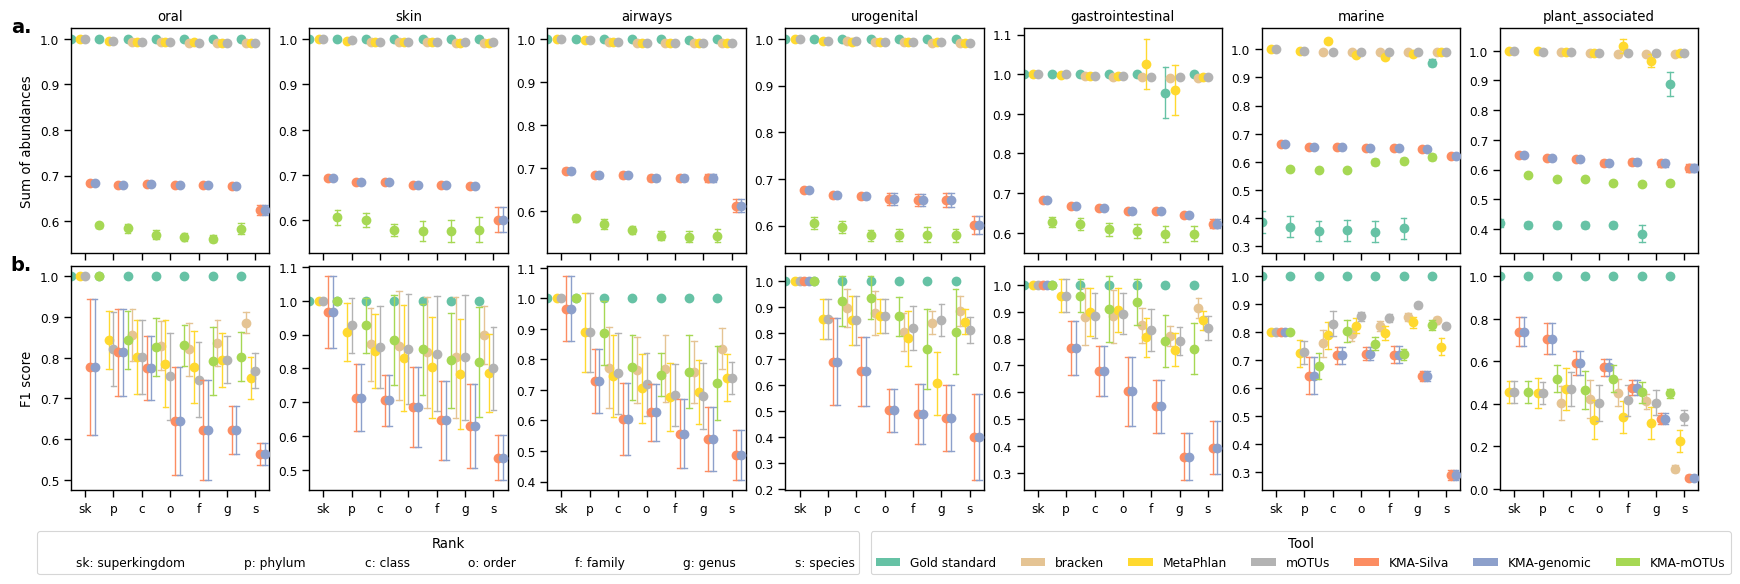

In [339]:
dim = 3
metrics = ['Sum of abundances','F1 score']

nmetrics = len(metrics)
nenvs = len(env_order)

fig, axes = plt.subplots(nmetrics, nenvs, figsize=(dim*nenvs, dim*nmetrics), sharex=True, gridspec_kw={'hspace': 0.06})

for i, metric in enumerate(metrics):
        
    for j, (ax, env) in enumerate(zip(axes[i, :].flatten(), env_order)):
        
        d = opal.loc[
            (opal['sample_group'] == env) &
            (opal['metric'] == metric) &
            (opal['rank'].isin(ranks))
        ].copy()
        
        d.loc[
        (d['rank'] == 'species') &
        (d['tool'] == 'KMA-mOTUs'),
        'value'
        ] = pd.NA
        
        d['x'] = d['rank'].map(rank2letter)
        
        sns.pointplot(
            data = d,
            x = 'x',
            y = 'value',
            hue = 'tool',
            hue_order=tool_order,
            palette=tool_palette,
            join=False,
            errorbar='sd',
            dodge=1,
            errwidth=1,
            ax=ax,
            capsize=.2

        )
        
        if i == 0:
            ax.set_title(env)
        

        if j == 0:
            ax.set_ylabel(metric)
            ax.text(-0.2, 1.05, alphabet[i] + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
        else:
            ax.set_ylabel('')
        
        ax.get_legend().remove()
        ax.set_xlabel('')
        
        
# add legends to bottom of plot
axes[-1, 0].legend(handles=rank_legend, ncol=len(rank_legend), title='Rank', loc='lower left', bbox_to_anchor=(-.2, -.4))
axes[-1, -3].legend(handles=tool_legend, ncol=len(tool_legend), title='Tool', loc='lower left', bbox_to_anchor=(-.8, -.4))

figure_saver(fig=fig, prefix='paper_figures/sumabn_f1_filtered', contexts=['talk', 'paper'])

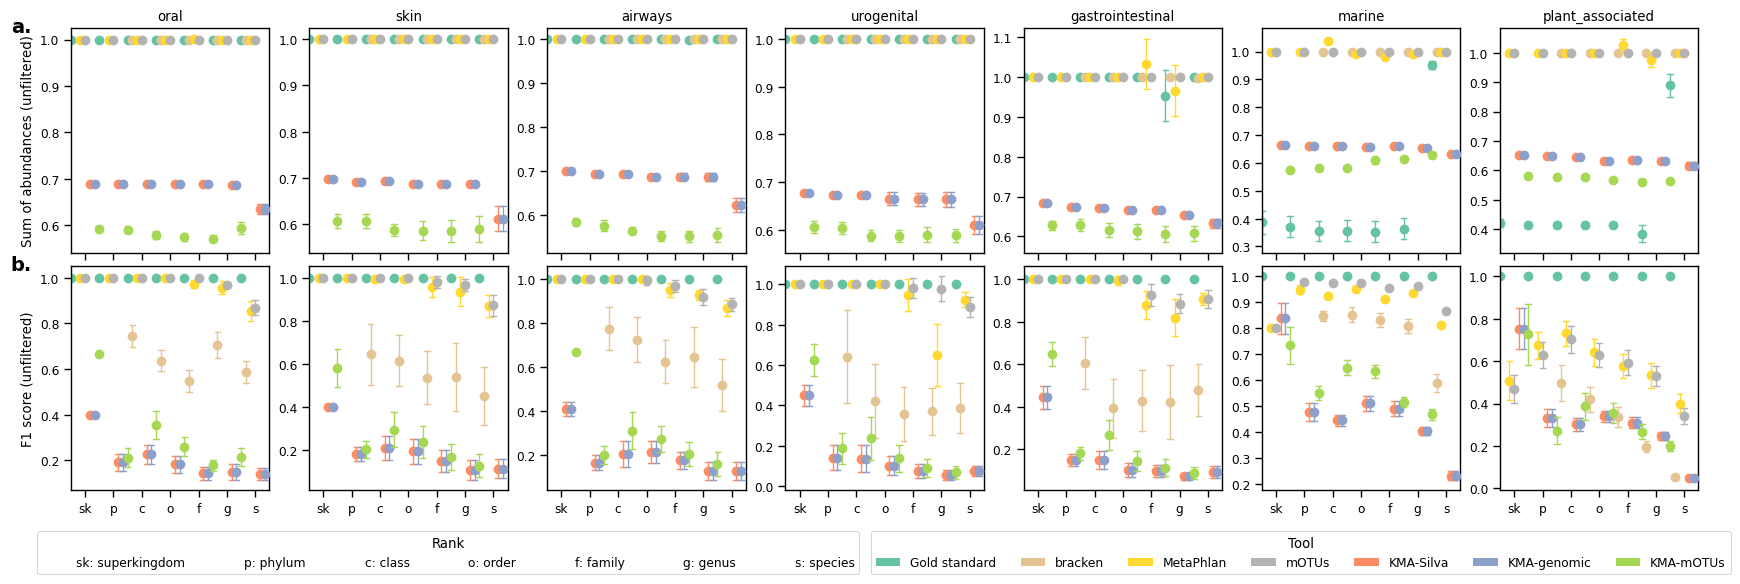

In [341]:
dim = 3
metrics = ['Sum of abundances (unfiltered)','F1 score (unfiltered)']

nmetrics = len(metrics)
nenvs = len(env_order)

fig, axes = plt.subplots(nmetrics, nenvs, figsize=(dim*nenvs, dim*nmetrics), sharex=True, gridspec_kw={'hspace': 0.06})

for i, metric in enumerate(metrics):
        
    for j, (ax, env) in enumerate(zip(axes[i, :].flatten(), env_order)):
        
        d = opal.loc[
            (opal['sample_group'] == env) &
            (opal['metric'] == metric) &
            (opal['rank'].isin(ranks))
        ].copy()
        
        d.loc[
        (d['rank'] == 'species') &
        (d['tool'] == 'KMA-mOTUs'),
        'value'
        ] = pd.NA
        
        d['x'] = d['rank'].map(rank2letter)
        
        sns.pointplot(
            data = d,
            x = 'x',
            y = 'value',
            hue = 'tool',
            hue_order=tool_order,
            palette=tool_palette,
            join=False,
            errorbar='sd',
            dodge=1,
            errwidth=1,
            ax=ax,
            capsize=.2

        )
        
        if i == 0:
            ax.set_title(env)
        

        if j == 0:
            ax.set_ylabel(metric)
            ax.text(-0.2, 1.05, alphabet[i] + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
        else:
            ax.set_ylabel('')
        
        ax.get_legend().remove()
        ax.set_xlabel('')
        
        
# add legends to bottom of plot
axes[-1, 0].legend(handles=rank_legend, ncol=len(rank_legend), title='Rank', loc='lower left', bbox_to_anchor=(-.2, -.4))
axes[-1, -3].legend(handles=tool_legend, ncol=len(tool_legend), title='Tool', loc='lower left', bbox_to_anchor=(-.8, -.4))

figure_saver(fig=fig, prefix='paper_figures/sumabn_f1_unfiltered', contexts=['talk', 'paper'])